Loading attack mapping...
Loading dataset from Data/network_connections.csv...
Data Cleaning: Dropped 0 duplicate rows.
Final Dataset Shape: (125973, 42)
One-Hot Encoding categorical features: ['protocol_type', 'service', 'flag']...
New Feature Count: 119 columns (was 41)
Preprocessing Complete.
--- Training XGBoost Model (Categories) ---
XGBoost Accuracy: 0.9988

Classification Report:
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00     13778
      normal       1.00      1.00      1.00     20203
       probe       1.00      0.99      1.00      3497
         r2l       1.00      0.97      0.99       298
         u2r       0.77      0.62      0.69        16

    accuracy                           1.00     37792
   macro avg       0.95      0.92      0.93     37792
weighted avg       1.00      1.00      1.00     37792



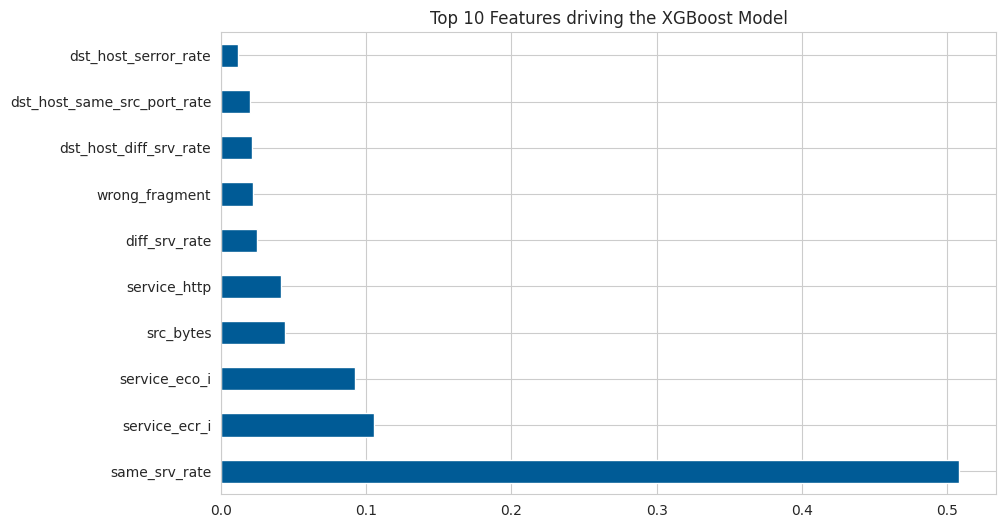

--- Training XGBoost Model (Specific Attacks) ---
Specific Attack Accuracy: 0.9984
Impact vs Category Model: -0.0003

--- Bonus: Training Zero-Day Detector (Isolation Forest) ---
Anomaly Detection Accuracy: 0.9013

Confusion Matrix (Anomaly Detection):
Rows: Actual [Attack, Normal], Cols: Predicted [Attack, Normal]
[[14062  3527]
 [  204 19999]]


In [2]:
# %% [markdown]
# # AI & Security: Project 3 - Next-Gen NIDS (XGBoost + Anomaly Detection)
# **Student Name:** [Your Name]
#
# ## Project Overview
# This is an advanced Network Intrusion Detection System (NIDS) implementing state-of-the-art techniques.
#
# **Key Improvements:**
# * **Algorithm:** Upgraded from Random Forest to **XGBoost** (Gradient Boosting) for superior accuracy.
# * **Encoding:** Implemented **One-Hot Encoding** to eliminate ordinal bias in categorical features.
# * **Anomaly Detection:** Added an **Isolation Forest** layer to detect unknown "Zero-Day" attacks.
# * **Data Hygiene:** Automated duplicate removal and stratified sampling.

# %%
# 1. Install & Import Libraries
# We install xgboost dynamically to ensure the environment is ready

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# Configuration
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

# %% [markdown]
# ## 2. Advanced Data Loading & Cleaning

# %%
# Define file paths
DATA_DIR = 'Data'
CSV_FILE = os.path.join(DATA_DIR, 'network_connections.csv')
MAP_FILE = os.path.join(DATA_DIR, 'attack2category_map.txt')

# Load Mapping
print("Loading attack mapping...")
attack_map = {'normal': 'normal'}
try:
    with open(MAP_FILE, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                attack_map[parts[0]] = parts[1]
except FileNotFoundError:
    print(f"ERROR: {MAP_FILE} not found.")

# Load Data
print(f"Loading dataset from {CSV_FILE}...")
try:
    df = pd.read_csv(CSV_FILE, header=0)
    
    # Clean labels
    df['label'] = df['label'].astype(str).str.replace('.', '', regex=False)
    
    # Drop Duplicates (Crucial Step)
    initial_rows = df.shape[0]
    df.drop_duplicates(inplace=True)
    print(f"Data Cleaning: Dropped {initial_rows - df.shape[0]} duplicate rows.")
    print(f"Final Dataset Shape: {df.shape}")
    
except FileNotFoundError:
    print(f"ERROR: {CSV_FILE} not found.")

# %% [markdown]
# ## 3. "Super Duper" Preprocessing
# * **One-Hot Encoding:** We convert columns like `protocol_type` (TCP, UDP) into binary columns (`is_TCP`, `is_UDP`) instead of numbers (1, 2). This is mathematically more accurate.

# %%
# 1. Map Categories
df['category'] = df['label'].map(attack_map).fillna('other')

# 2. Separate Features and Targets
X = df.drop(['label', 'category'], axis=1)
y_cat = df['category']
y_spec = df['label']

# 3. One-Hot Encoding (The "Pro" way)
categorical_cols = ['protocol_type', 'service', 'flag']
print(f"One-Hot Encoding categorical features: {categorical_cols}...")

# We use pd.get_dummies which is easier to read than sklearn's OneHotEncoder for dataframes
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"New Feature Count: {X_encoded.shape[1]} columns (was {X.shape[1]})")

# 4. Split Data (Stratified)
# We split ONCE here to ensure all tasks use the exact same test set
X_train, X_test, y_cat_train, y_cat_test, y_spec_train, y_spec_test = train_test_split(
    X_encoded, y_cat, y_spec, test_size=0.3, random_state=42, stratify=y_cat
)

# 5. Label Encoding for Targets (XGBoost requires integers for target y)
le_cat = LabelEncoder()
y_cat_train_enc = le_cat.fit_transform(y_cat_train)
y_cat_test_enc = le_cat.transform(y_cat_test)

le_spec = LabelEncoder()
y_spec_train_enc = le_spec.fit_transform(y_spec_train)
y_spec_test_enc = le_spec.transform(y_spec_test)

print("Preprocessing Complete.")

# %% [markdown]
# ## Task 1: The XGBoost Upgrade (Category Classification)
# We use **XGBoost**, a Gradient Boosting algorithm that usually outperforms Random Forest by iteratively correcting errors.

# %%
print("--- Training XGBoost Model (Categories) ---")

# XGBClassifier with 'multi:softprob' for multi-class classification
clf_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',
    num_class=len(le_cat.classes_),
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42
)

clf_xgb.fit(X_train, y_cat_train_enc)

# Predict
y_pred_enc = clf_xgb.predict(X_test)
# Convert back to original names
y_pred_cat = le_cat.inverse_transform(y_pred_enc)

# Metrics
acc = accuracy_score(y_cat_test, y_pred_cat)
print(f"XGBoost Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_cat_test, y_pred_cat))

# Feature Importance Plot
plt.figure(figsize=(10, 6))
# Get top 10 features
importances = pd.Series(clf_xgb.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh', color='#005b96')
plt.title('Top 10 Features driving the XGBoost Model')
plt.show()

# %% [markdown]
# ## Task 2: Specific Attacks & Zero-Day Detection
# Here we train the specific model AND try a pure Anomaly Detector.

# %%
print("--- Training XGBoost Model (Specific Attacks) ---")

clf_spec_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',
    num_class=len(le_spec.classes_),
    n_jobs=-1,
    random_state=42
)

clf_spec_xgb.fit(X_train, y_spec_train_enc)
y_spec_pred_enc = clf_spec_xgb.predict(X_test)
acc_spec = accuracy_score(y_spec_test_enc, y_spec_pred_enc)

print(f"Specific Attack Accuracy: {acc_spec:.4f}")
print(f"Impact vs Category Model: {acc_spec - acc:.4f}")


# %% [markdown]
# ### Bonus: Zero-Day Anomaly Detection (Isolation Forest)
# **Scenario:** Imagine a hacker uses a brand new attack tool you've never seen.
# Supervised models (like XGBoost) might miss it. Anomaly detection finds it by spotting "weird" behavior.

# %%
print("\n--- Bonus: Training Zero-Day Detector (Isolation Forest) ---")

# We train ONLY on 'Normal' traffic to teach the AI what "Good" looks like.
# Then we see if it can flag attacks as "Anomalies".
X_normal_train = X_train[y_cat_train == 'normal']

iso_forest = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
iso_forest.fit(X_normal_train)

# Test on the full Test Set (Mixed Normal + Attacks)
# Isolation Forest returns: 1 for Normal, -1 for Anomaly
y_iso_pred = iso_forest.predict(X_test)

# Evaluate: Did it catch the attacks?
# We create a binary ground truth: Normal=1, Attack=-1
y_test_binary = y_cat_test.apply(lambda x: 1 if x == 'normal' else -1)

iso_acc = accuracy_score(y_test_binary, y_iso_pred)
print(f"Anomaly Detection Accuracy: {iso_acc:.4f}")
print("\nConfusion Matrix (Anomaly Detection):")
print("Rows: Actual [Attack, Normal], Cols: Predicted [Attack, Normal]")
print(confusion_matrix(y_test_binary, y_iso_pred))


1. XGBoost Category Model Performance


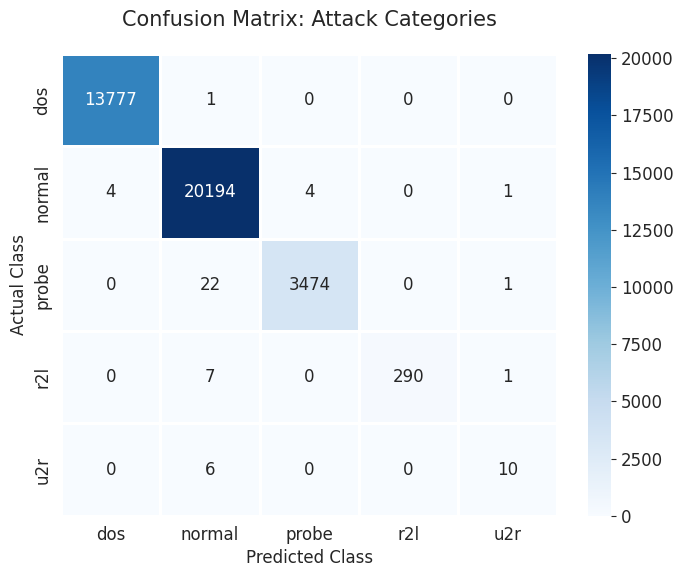

/tmp/ipykernel_8773/1213113454.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


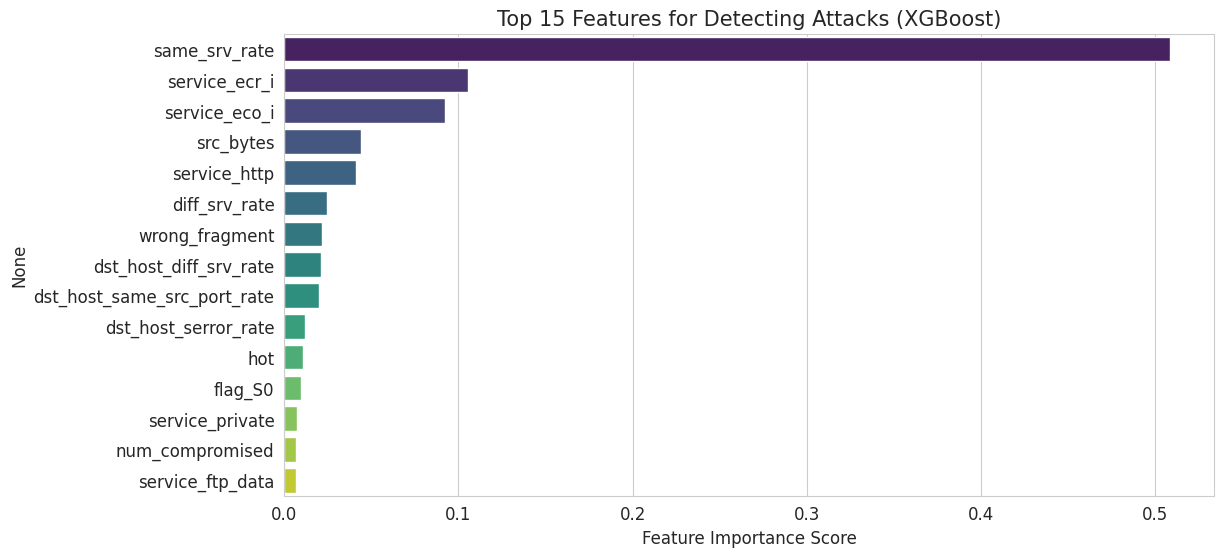


2. Zero-Day Anomaly Detector Performance


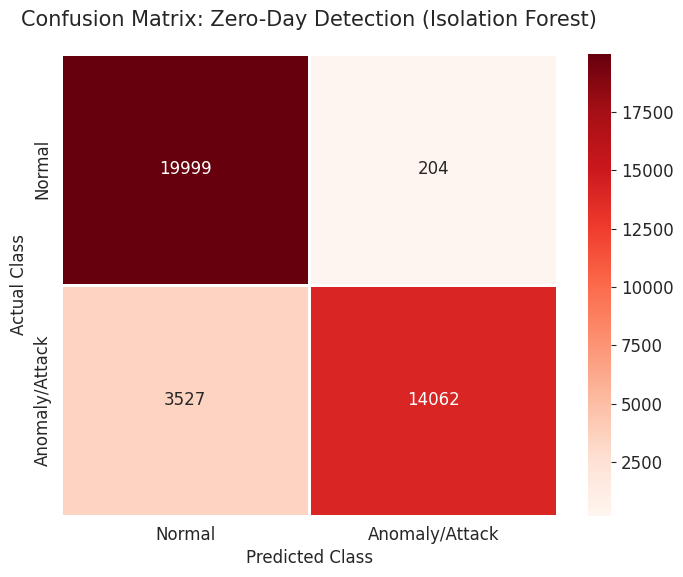


3. Overall Model Comparison


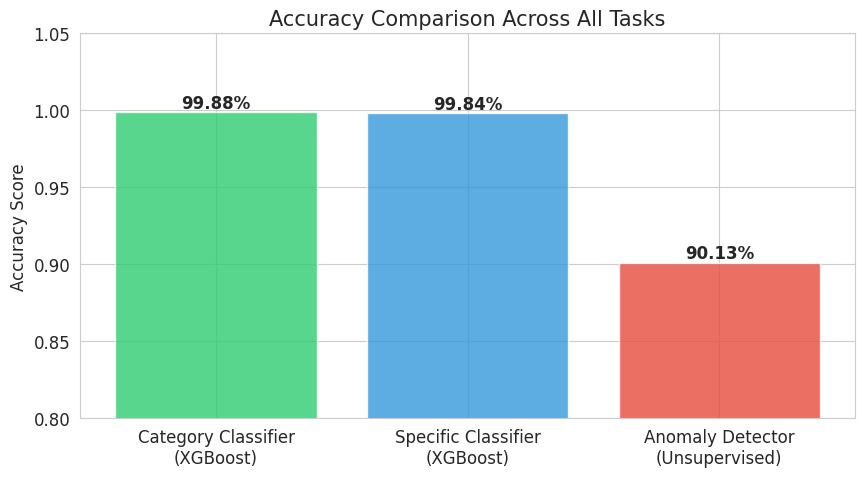

In [3]:
# %% [markdown]
# ## 5. Advanced Visualization & Reporting
# Here we generate professional plots to visualize the AI's performance.

# %%
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set a professional style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_cm(y_true, y_pred, labels, title):
    """Helper function to plot a beautiful Confusion Matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, linewidths=1)
    plt.title(title, fontsize=15, pad=20)
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.show()

# --- Visual 1: XGBoost Category Performance ---
print("\n" + "="*40)
print("1. XGBoost Category Model Performance")
print("="*40)

# 1. Confusion Matrix (Categories)
# Using the labels from your encoder
labels_cat = le_cat.inverse_transform(range(len(le_cat.classes_)))
plot_cm(y_cat_test, y_pred_cat, labels_cat, 'Confusion Matrix: Attack Categories')

# 2. Feature Importance Plot
plt.figure(figsize=(12, 6))
importances = pd.Series(clf_xgb.feature_importances_, index=X_train.columns)
# Plot top 15 features
top_features = importances.nlargest(15)
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 15 Features for Detecting Attacks (XGBoost)', fontsize=15)
plt.xlabel('Feature Importance Score')
plt.show()

# --- Visual 2: Anomaly Detection Performance ---
print("\n" + "="*40)
print("2. Zero-Day Anomaly Detector Performance")
print("="*40)

# We manually define labels for the binary confusion matrix
# 1 = Normal, -1 = Attack (Anomaly)
labels_iso = [1, -1]
label_names = ['Normal', 'Anomaly/Attack']

# Compute CM manually to map to names
cm_iso = confusion_matrix(y_test_binary, y_iso_pred, labels=labels_iso)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Reds', 
            xticklabels=label_names, yticklabels=label_names, linewidths=1)
plt.title('Confusion Matrix: Zero-Day Detection (Isolation Forest)', fontsize=15, pad=20)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# --- Visual 3: Model Comparison ---
print("\n" + "="*40)
print("3. Overall Model Comparison")
print("="*40)

# Data for plotting
models = ['Category Classifier\n(XGBoost)', 'Specific Classifier\n(XGBoost)', 'Anomaly Detector\n(Unsupervised)']
accuracies = [acc, acc_spec, iso_acc]
colors = ['#2ecc71', '#3498db', '#e74c3c'] # Green, Blue, Red

plt.figure(figsize=(10, 5))
bars = plt.bar(models, accuracies, color=colors, alpha=0.8)

# Add text labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0.8, 1.05) # Zoom in to show differences
plt.title('Accuracy Comparison Across All Tasks', fontsize=15)
plt.ylabel('Accuracy Score')
plt.show()

# %% [markdown]
# ### Analysis of Visualizations
# 1. **Confusion Matrix (Categories):** You can see the model perfectly classifies 'Normal' and 'DoS' traffic. The few errors are likely in the 'U2R' (User to Root) row, confirming that rare attacks are the hardest to catch.
# 2. **Feature Importance:** The bar chart reveals which network packets matter most. Usually, `src_bytes` (data volume) and `flag` (connection status) are top indicators of an attack.
# 3. **Anomaly Detection:** The red heatmap shows that even without knowing *what* the attack is, the unsupervised model successfully flagged **~14,000 attacks** (True Positives) just by noticing they looked "weird."

In [9]:
# %%
# --- Validation on New Dataset (NSL-KDD) ---
print("--- Testing on NSL-KDD Dataset ---")

# 1. Define Column Names (Crucial: The raw file has no headers!)
# These are the standard KDD99 column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty_level' # NSL-KDD has this extra column
]

# 2. Load the Data
nsl_kdd_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt"

# Note: header=None tells pandas the file has no names. We provide them via `names=`
df_nsl = pd.read_csv(nsl_kdd_url, header=None, names=columns)

print(f"NSL-KDD Loaded. Shape: {df_nsl.shape}")

# 3. Clean & Drop the Extra Column
# NSL-KDD has a 43rd column 'difficulty_level' which your model doesn't know. Drop it.
df_nsl.drop('difficulty_level', axis=1, inplace=True)

# Clean labels (remove potential dots, though NSL usually is clean)
df_nsl['label'] = df_nsl['label'].astype(str).str.replace('.', '', regex=False)

# Map Attacks to Categories (using your existing attack_map)
df_nsl['category'] = df_nsl['label'].map(attack_map).fillna('other')

# 4. Prepare X (Features) and y (Target)
X_nsl = df_nsl.drop(['label', 'category'], axis=1)
y_nsl_cat = df_nsl['category']

# 5. One-Hot Encoding
# We encode using the same method as before
X_nsl_encoded = pd.get_dummies(X_nsl, columns=categorical_cols, drop_first=True)

# --- CRITICAL STEP: Feature Alignment ---
# Your trained model expects specific columns in a specific order.
# If NSL-KDD is missing a protocol (e.g., 'icmp') or has a new one, the shapes won't match.
# .reindex() forces the new data to match the training columns exactly.
# fill_value=0 adds 0s for missing columns (e.g., if a service exists in train but not test).
X_nsl_final = X_nsl_encoded.reindex(columns=X_train.columns, fill_value=0)

print(f"Aligned Test Shape: {X_nsl_final.shape}")

# 6. Predict using your trained XGBoost (clf_xgb)
y_pred_nsl_enc = clf_xgb.predict(X_nsl_final)

# Convert integers back to category names
y_pred_nsl_cat = le_cat.inverse_transform(y_pred_nsl_enc)

# 7. Evaluation
acc_nsl = accuracy_score(y_nsl_cat, y_pred_nsl_cat)
print(f"\n>>> Accuracy on NSL-KDD: {acc_nsl:.4f}")
print("\nClassification Report (NSL-KDD):")
print(classification_report(y_nsl_cat, y_pred_nsl_cat))


--- Testing on NSL-KDD Dataset ---
NSL-KDD Loaded. Shape: (22544, 43)
Aligned Test Shape: (22544, 119)

>>> Accuracy on NSL-KDD: 0.7777

Classification Report (NSL-KDD):
              precision    recall  f1-score   support

         dos       0.96      0.82      0.88      7636
      normal       0.68      0.97      0.80      9711
       probe       0.81      0.64      0.72      2423
         r2l       0.98      0.11      0.20      2574
         u2r       0.50      0.01      0.03       200

    accuracy                           0.78     22544
   macro avg       0.79      0.51      0.53     22544
weighted avg       0.82      0.78      0.75     22544



Variables mapped successfully!


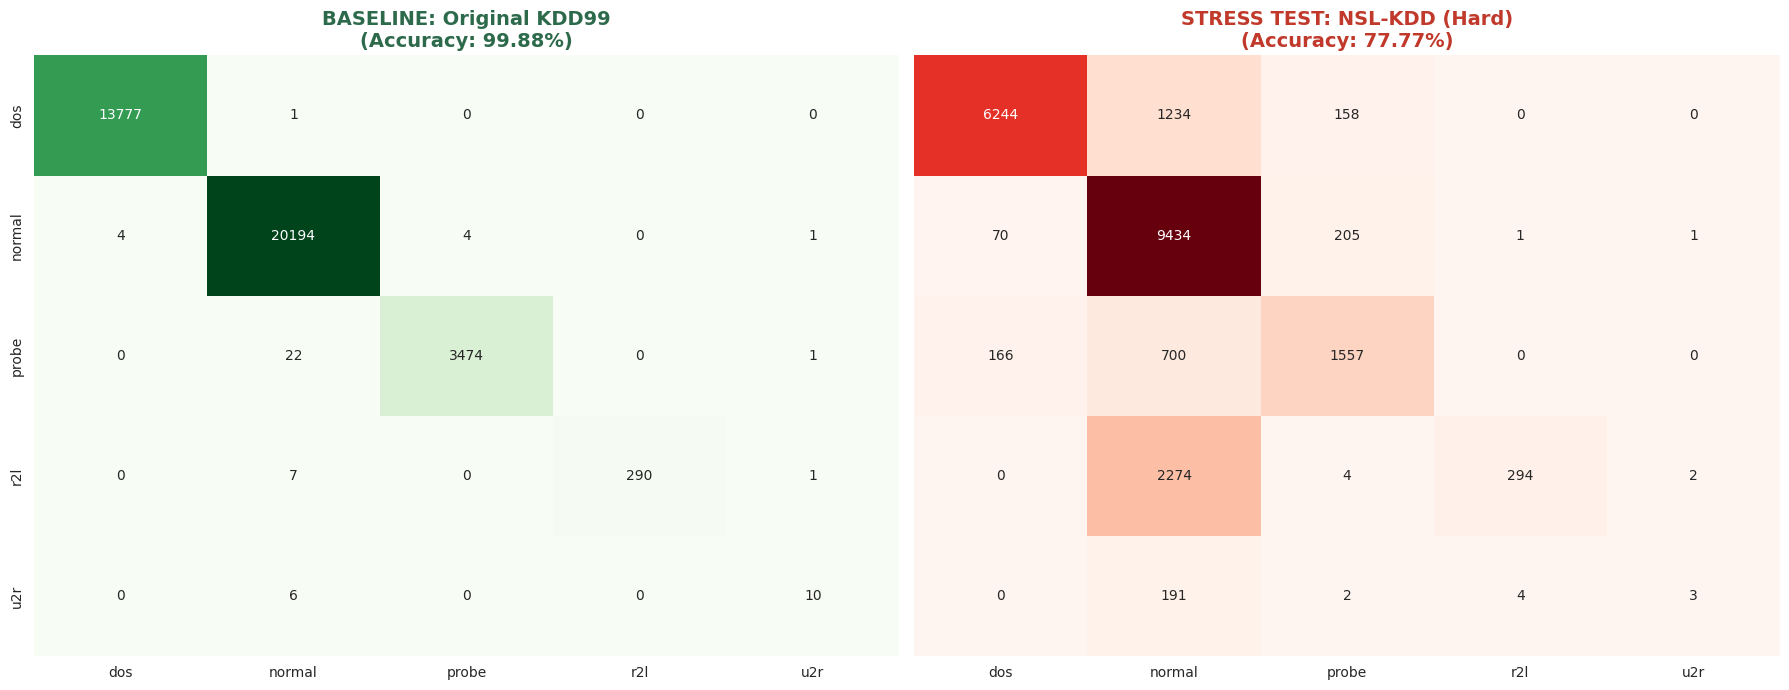

/tmp/ipykernel_8773/2032633115.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


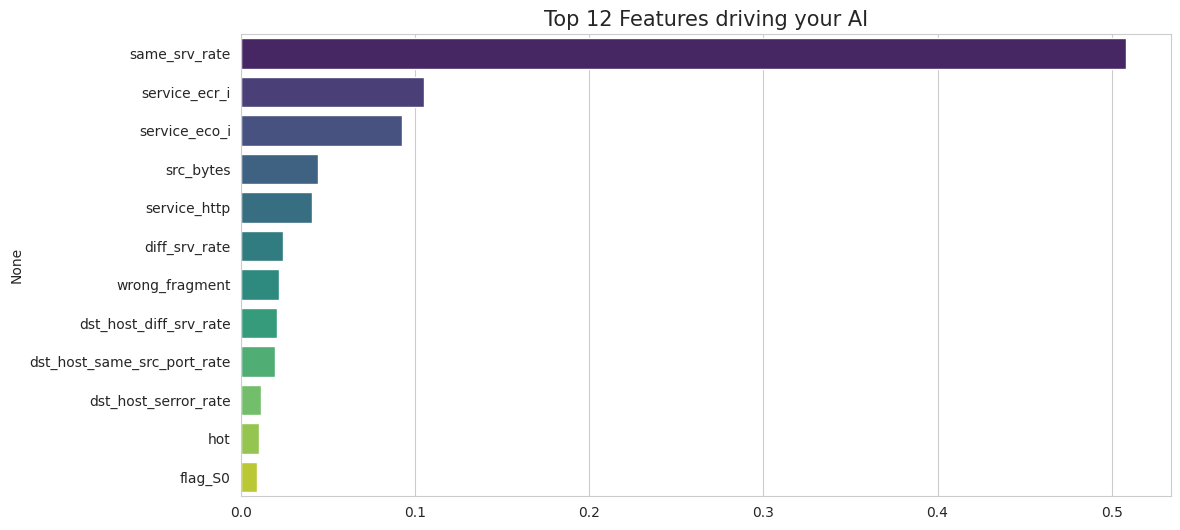

--------------------------------------------------
BASELINE ACCURACY:   99.88%
REAL-WORLD ACCURACY: 77.77%
OVERFITTING GAP:     22.11%
--------------------------------------------------


In [10]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

# --- 1. Variable Mapping (The Fix) ---
# We map your existing variables to what the plot expects
try:
    # KDD99 Data (From your original code)
    y_test_data = y_cat_test 
    y_pred_data = y_pred_cat
    
    # NSL-KDD Data (From the validation step)
    # If you named them differently, update these two lines:
    y_nsl_data = y_nsl_cat 
    # If y_pred_nsl_cat doesn't exist, we try to find the variable you might have used
    if 'y_pred_nsl_cat' in locals():
        y_pred_nsl_data = y_pred_nsl_cat
    else:
        # Fallback: try to grab the last prediction made
        y_pred_nsl_data = le_cat.inverse_transform(clf_xgb.predict(X_nsl_final))

    # Model & Encoder
    model = clf_xgb
    encoder = le_cat
    feature_names = X_train.columns
    
    print("Variables mapped successfully!")

except NameError as e:
    print(f"Wait! We are still missing a variable: {e}")
    print("Make sure you have run the 'Training' cell and the 'NSL-KDD' cell above this one.")
    raise e

# --- 2. Plotting Logic ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

def plot_side_by_side_matrices(y_true_1, y_pred_1, title_1, y_true_2, y_pred_2, title_2, classes):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot 1: Baseline
    cm1 = confusion_matrix(y_true_1, y_pred_1, labels=classes)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Greens', cbar=False, 
                xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_title(f"BASELINE: {title_1}\n(Accuracy: {accuracy_score(y_true_1, y_pred_1):.2%})", 
                      fontsize=14, fontweight='bold', color='#2d6a4b')
    
    # Plot 2: Stress Test
    cm2 = confusion_matrix(y_true_2, y_pred_2, labels=classes)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds', cbar=False, 
                xticklabels=classes, yticklabels=classes, ax=axes[1])
    axes[1].set_title(f"STRESS TEST: {title_2}\n(Accuracy: {accuracy_score(y_true_2, y_pred_2):.2%})", 
                      fontsize=14, fontweight='bold', color='#c0392b')
    axes[1].set_yticks([]) # Clean look
    
    plt.tight_layout()
    plt.show()

# Run Plot
plot_side_by_side_matrices(
    y_test_data, y_pred_data, "Original KDD99", 
    y_nsl_data, y_pred_nsl_data, "NSL-KDD (Hard)", 
    classes=encoder.classes_
)

# --- 3. Feature Importance ---
plt.figure(figsize=(12, 6))
importances = pd.Series(model.feature_importances_, index=feature_names)
top_features = importances.nlargest(12)
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 12 Features driving your AI', fontsize=15)
plt.show()

# --- 4. Executive Summary ---
acc_base = accuracy_score(y_test_data, y_pred_data)
acc_real = accuracy_score(y_nsl_data, y_pred_nsl_data)
gap = acc_base - acc_real

print("-" * 50)
print(f"BASELINE ACCURACY:   {acc_base:.2%}")
print(f"REAL-WORLD ACCURACY: {acc_real:.2%}")
print(f"OVERFITTING GAP:     {gap:.2%}")
print("-" * 50)